In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from parse_levels import find_levels_in_configs, find_levels_in_configs_glob
from parse_levels import process_metrics, human_train_time_dict, convert_to_dict, compute_gap_in_percentage
from parse_levels import filter_folder_info
import pandas as pd
import matplotlib.ticker as ticker
from plot_utils import plot_gap_comparison, gather_metrics
import re
import copy
import json
import torch

In [2]:
# for each item in the dict, if any two have the same 'record',
# keep the one that has the lowest train_time
def deduplicate_metrics(search_results):
    # records_length_so_far = {}
    # new_search_results = {}
    # for key, value in search_results.items():
    #     if value['record'] not in records_length_so_far:
    #         records_length_so_far[value['record']] = (len(value['metrics']['step']), key)
    #         new_search_results[key] = value
    #     else:
    #         if len(value['metrics']['step']) > records_length_so_far[value['record']][0]:
    #             new_search_results.pop(records_length_so_far[value['record']][1])

    #             records_length_so_far[value['record']] = (len(value['metrics']['step']), key)
    #             new_search_results[key] = value
    # return new_search_results
    records_train_time_so_far = {}
    new_search_results = {}
    for key, value in search_results.items():
        # get the min value where the train_time is not smaller than 40% of the train_time at 0
        base_train_time = value['metrics']['train_time'].tolist()[0]
        train_time_array = value['metrics']['train_time'].to_numpy()
        train_time = train_time_array[train_time_array >= 0.4 * base_train_time].min()
        # train_time = value['metrics']['train_time'].min()
        if value['record'] not in records_train_time_so_far:
            # get the min train time
            records_train_time_so_far[value['record']] = (train_time, key)
            new_search_results[key] = value
        else:
            if train_time < records_train_time_so_far[value['record']][0]:
                new_search_results.pop(records_train_time_so_far[value['record']][1])

                records_train_time_so_far[value['record']] = (train_time, key)
                new_search_results[key] = value
    return new_search_results


In [3]:
# ori_results = find_levels_in_configs_glob(
#     [
#         '/checkpoint/maui/zhaobc/scientist/workspace/record_*',
#         # '/checkpoint/maui/zhaobc/scientist/workspace/record_*_20250424_*',
#         # '/checkpoint/maui/zhaobc/scientist/workspace/record_*_20250425_*',
#         # '/checkpoint/maui/zhaobc/scientist/workspace/record_*_20250405_*'
#         # '/checkpoint/maui/zhaobc/scientist/workspace/record_1[2-8]_20250412_*',
#         #  '/checkpoint/maui/zhaobc/scientist/workspace/record_*_20250408_*',
#         # '/checkpoint/maui/zhaobc/scientist/workspace/record_*_20250405_*'
#         # '/checkpoint/maui/zhaobc/scientist/workspace/record_1[2-8]_20250409_*',
#     ]
# )

In [4]:
# with open('may5.cache', 'w') as f:
#     json.dump(ori_results, f)
with open('/home/zhaobc/scientist/plot/june1.cache', 'r') as f:
    ori_results = json.load(f)

In [5]:
folder_info = ori_results
len(folder_info)

5409

In [10]:
# flat search -- n_initial_hypotheses = 50
flat_params = [
    ('runner', 'bon'),
    # ('n_initial_hypotheses', 50),
    ('n_iterations', 1),
]
# tree search -- n_initial_hypotheses = 1, n_hypotheses = 3
tree_params = [
    ('runner', 'bon'),
    ('n_initial_hypotheses', 1),
    ('n_hypotheses', 3),
]
# forest search -- n_initial_hypotheses = 3, n_hypotheses = 3
forest_params = [
    ('runner', 'bon'),
    ('n_initial_hypotheses', 3),
    ('n_hypotheses', 3),
]
# AIDE -- n_initial_hypotheses = 3, n_hypotheses = 1, debug_prob = 0.5
aide_params = [
    ('runner', 'aide'),
    ('n_initial_hypotheses', 3),
    ('n_hypotheses', 1),
    ('debug_prob', 0.5),
]
# MultiAIDE -- n_initial_hypotheses = 3, n_hypotheses = 3, debug_prob = 0.5
multi_aide_params = [
    ('runner', 'aide'),
    ('n_initial_hypotheses', 3),
    ('n_hypotheses', 3),
    ('debug_prob', 0.5),
]
# for each search algo, we get the R1 and O3 with level 1, 12, 125 results for plotting
# thats 6 results for each search algo, so we plot with 3 columns (level) and 2 rows (R1 and O3)

search_algo_params = {
    'flat': flat_params,
    'tree': tree_params,
    'forest': forest_params,
    'aide': aide_params,
    'multi_aide': multi_aide_params,
}

plot_info = {}

for search_algo, params in search_algo_params.items():
    plot_info[search_algo] = {}
    for level in [1, 12, 125]:
        plot_info[search_algo][level] = {}
        for model in ['deepseek-r1', 'o3-mini', 'gemini-2.5-pro']:
            search_params = params + [('levels', level), ('model', model)]
            filtered_folder_info = filter_folder_info(folder_info, search_params)
            # print(f'{search_algo} {level} {model} {len(filtered_folder_info)}')
            plot_info[search_algo][level][model] = filtered_folder_info

In [11]:
figure_data = {}
for search_algo in search_algo_params.keys():
    for level in [1, 12, 125]:
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
            try:
                plot_info[search_algo][level][model] = process_metrics(plot_info[search_algo][level][model])
                plot_info[search_algo][level][model] = deduplicate_metrics(plot_info[search_algo][level][model])
                figure_data[f'{search_algo}_{level}_{model}'] = convert_to_dict(plot_info[search_algo][level][model])
            except FileNotFoundError as e:
                print(f"File not found while processing metrics for {search_algo}, level {level}, model {model}: {e}")


In [12]:
len(plot_info['flat'][12]['gemini-2.5-pro'].keys())

19

In [13]:
human_train_time_dict = {
    1: 2968348,
    2: 2209926,
    3: 1386147,
    4: 1301740,
    5: 949528,
    6: 766259,
    7: 773072,
    8: 662205,
    9: 505531,
    10: 477150,
    11: 442985,
    12: 317839,
    13: 289805,
    14: 273107,
    15: 241463,
    16: 232971,
    17: 220374,
    18: 211840,
    19: 199442,
    20: 188680,
    21: 184262
}

human_train_time_variance = {
    1: 20183.68,
    2: 18300.36,
    3: 22270.99,
    4: 37980.47,
    5: 7365.53,
    6: 5922.16,
    7: 3805.14,
    8: 9496.43,
    9: 15747.18,
    10: 2315.29,
    11: 3259.97,
    12: 1220.16,
    13: 927.61,
    14: 6034.27,
    15: 2337.85,
    16: 6700.25,
    17: 40.5,
    18: 1495.18,
    19: 600.67,
    20: 770.64,
    21: 593.64,
}

In [14]:
for key in figure_data.keys():
    figure_data[key] = compute_gap_in_percentage(figure_data[key], human_train_time_dict)
    figure_data[key] = {str(k): v for k, v in figure_data[key].items()}
    if '6' in figure_data[key]:
        # print(f'removing {key} 6')
        del figure_data[key]['6']

# replace the ones with 300% improvement with 0 as they might be summarizer mistakes
for key in figure_data.keys():
    for k, v in figure_data[key].items():
        if v > 3 or v < 0:
            # print(f'found {v} in {key} {k}')
            figure_data[key][k] = 0.


In [15]:
from parse_levels import workspace_base_path, list_of_base_paths

In [17]:
for search_algo in search_algo_params.keys():
    for level in [1, 12, 125]:
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
        # for model in ['gemini-2.5-pro']:
            for key in plot_info[search_algo][level][model].keys():
                folder_path = workspace_base_path(key)
                for base_path in list_of_base_paths:
                    folder_path = os.path.join(base_path, key)
                    if os.path.exists(folder_path):
                        break
                new_keys = {
                    'code_length': [],
                    'is_valid': [],
                    'debug_depth': [],
                    'train_time': [],
                }

                # if model == 'gemini-2.5-pro':
                #     break
                # take the first 20 versions
                for v in range(0, 21):

                    # get code length for each version
                    try:
                        code_file = os.path.join(folder_path, f'v_{v}', 'train_gpt2.py')
                        with open(code_file, 'r') as f:
                            code = f.readlines()
                        new_keys['code_length'].append(len(code))
                    except:
                        new_keys['code_length'].append(0)

                    # get is_valid for each version
                    results_file = os.path.join(folder_path, f'v_{v}', 'results.json')
                    try:
                        with open(results_file, 'r') as f:
                            results = json.load(f)
                        try:
                            new_keys['is_valid'].append(results['metrics']['is_valid'])
                        except KeyError:
                            new_keys['is_valid'].append(True)
                    except:
                        new_keys['is_valid'].append(False)

                    try:
                        with open(results_file, 'r') as f:
                            results = json.load(f)
                        try:
                            new_keys['train_time'].append(results['metrics']['train_time'])
                        except KeyError:
                            new_keys['train_time'].append(-1)
                    except:
                        new_keys['train_time'].append(-1)

                    # get debug_depth for each version
                    debug_depth_file = os.path.join(folder_path, f'v_{v}', 'meta.json')
                    try:
                        with open(debug_depth_file, 'r') as f:
                            debug_depth = json.load(f)
                        try:
                            new_keys['debug_depth'].append(debug_depth['bug_depth'])
                        except KeyError:
                            new_keys['debug_depth'].append(0)
                    except:
                        new_keys['debug_depth'].append(-1)

                # metrics = plot_info[search_algo][level][model][key]['metrics']
                # metrics = pd.DataFrame(new_keys).join(metrics)
                metrics = pd.DataFrame(new_keys)
                plot_info[search_algo][level][model][key]['metrics'] = metrics

In [18]:
# plot buggy percentage
buggy_percentage = {}
for search_algo in search_algo_params.keys():
    buggy_percentage[search_algo] = {}
    for level in [1, 12, 125]:
        buggy_percentage[search_algo][level] = {}
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
            buggy_percentage[search_algo][level][model] = {}
            for key, value in plot_info[search_algo][level][model].items():
                non_buggy_count = sum(value['metrics']['is_valid'])
                buggy_percentage[search_algo][level][model][value['record']] = \
                    1 - non_buggy_count / len(value['metrics']['is_valid'])

In [19]:
# colors = ['crimson', 'royalblue', 'forestgreen', 'darkorange', 'purple', 'pink']
# for search_algo in ['flat', 'tree', 'forest', 'aide', 'multi_aide']:
#     filtered_figure_data = {k: v for k, v in buggy_percentage.items() if search_algo in k}
#     data_dicts = []
#     i = 0
#     for model in ('deepseek-r1', 'o3-mini'):
#         for level in [1, 12, 125]:
#             if level == 125:
#                 level_plot = 123
#             else:
#                 level_plot = level
#             data_dicts.append((
#                 buggy_percentage[search_algo][level][model],
#                 f'hints: {level_plot} model: {model}',
#                 colors[i]
#             ))
#             i += 1
#     plot_gap_comparison(
#         data_dicts,
#         figsize=(15, 10),
#         # n_cols=3,
#         main_title=f'Buggy Percentage: {search_algo}'
#     )
#     # plt.savefig(f'../figures/{search_algo}_placeholder.pdf', dpi=150)
#     plt.show()

In [20]:
# plot faulty percentage
buggy_percentage_2 = {}
for search_algo in search_algo_params.keys():
    buggy_percentage_2[search_algo] = {}
    for level in [1, 12, 125]:
        buggy_percentage_2[search_algo][level] = {}
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
            buggy_percentage_2[search_algo][level][model] = {}
            for key, value in plot_info[search_algo][level][model].items():
                # print(value['metrics']['debug_depth'])
                # print(sum(value['metrics']['debug_depth'] > 0))
                buggy_count = sum(value['metrics']['debug_depth'] > 0)
                buggy_percentage_2[search_algo][level][model][value['record']] = \
                    buggy_count / len(value['metrics']['debug_depth'])

In [21]:
# plot faulty percentage for first k nodes
buggy_percentage_first_k = {}
for search_algo in search_algo_params.keys():
    buggy_percentage_first_k[search_algo] = {}
    for level in [1, 12, 125]:
        buggy_percentage_first_k[search_algo][level] = {}
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
            buggy_percentage_first_k[search_algo][level][model] = {}
            for key, value in plot_info[search_algo][level][model].items():
                # Calculate buggy percentage for different k values
                debug_depths = value['metrics']['debug_depth']
                buggy_percentages_by_k = {}
                for k in range(1, len(debug_depths) + 1):
                    # Get first k debug depths
                    depths_k = debug_depths.iloc[:k]
                    # Calculate percentage of buggy solutions
                    buggy_count = sum(depths_k > 0)
                    buggy_percentages_by_k[k] = buggy_count / k
                buggy_percentage_first_k[search_algo][level][model][value['record']] = buggy_percentages_by_k

In [22]:
# plot minimum train time for first k nodes
min_train_time_first_k = {}
for search_algo in search_algo_params.keys():
    min_train_time_first_k[search_algo] = {}
    for level in [1, 12, 125]:
        min_train_time_first_k[search_algo][level] = {}
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
            min_train_time_first_k[search_algo][level][model] = {}
            for key, value in plot_info[search_algo][level][model].items():
                # Calculate minimum train time for different k values
                train_times = value['metrics']['train_time']
                is_valid = value['metrics']['is_valid']
                min_times_by_k = {}
                for k in range(1, len(train_times) + 1):
                    # Get first k train times and validity flags
                    times_k = train_times.iloc[:k]
                    valid_k = is_valid.iloc[:k]
                    # Calculate minimum train time among valid solutions
                    valid_times = times_k[valid_k]
                    if len(valid_times) > 0:
                        min_time = valid_times.min()
                    else:
                        min_time = float('inf')  # No valid solutions found yet
                    min_times_by_k[k] = min_time
                min_train_time_first_k[search_algo][level][model][value['record']] = min_times_by_k

In [23]:
human_train_time_dict = {
    1: 2968348,
    2: 2209926,
    3: 1386147,
    4: 1301740,
    5: 949528,
    6: 766259,
    7: 773072,
    8: 662205,
    9: 505531,
    10: 477150,
    11: 442985,
    12: 317839,
    13: 289805,
    14: 273107,
    15: 241463,
    16: 232971,
    17: 220374,
    18: 211840,
    19: 199442,
    20: 188680,
    21: 184262
}


In [25]:
no_improvement = {}
for search_algo in search_algo_params.keys():
    no_improvement[search_algo] = {}
    for level in [1, 12, 125]:
        no_improvement[search_algo][level] = {}
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
            no_improvement[search_algo][level][model] = {}
            for key, value in plot_info[search_algo][level][model].items():
                record_id = value['record']
                human_time = human_train_time_dict[record_id]
                variance = human_train_time_variance[record_id]

                agent_times = value['metrics']['train_time'][value['metrics']['is_valid']].to_numpy()[1:]
                no_improvement[search_algo][level][model][record_id] = sum(agent_times > (human_time + variance)) / len(value['metrics']['is_valid'])


In [26]:
no_improvement_first_k = {}
for search_algo in search_algo_params.keys():
    no_improvement_first_k[search_algo] = {}
    for level in [1, 12, 125]:
        no_improvement_first_k[search_algo][level] = {}
        for model in ('deepseek-r1', 'o3-mini', 'gemini-2.5-pro'):
            no_improvement_first_k[search_algo][level][model] = {}
            for key, value in plot_info[search_algo][level][model].items():
                record_id = value['record']
                human_time = human_train_time_dict[record_id]
                variance = human_train_time_variance[record_id]

                # Calculate no improvement percentage for different k values
                train_times = value['metrics']['train_time']
                is_valid = value['metrics']['is_valid']
                no_improvement_by_k = {}
                for k in range(1, len(train_times) + 1):
                    # Get first k valid solutions and their times
                    valid_times_k = train_times[is_valid].iloc[:k].to_numpy()
                    if len(valid_times_k) > 0:
                        # Skip first solution as it's the baseline
                        valid_times_k = valid_times_k[1:]
                        if len(valid_times_k) > 0:
                            # Calculate percentage of solutions with no improvement
                            no_improvement_count = sum(valid_times_k > (human_time + variance))
                            no_improvement_by_k[k] = no_improvement_count / k
                        else:
                            no_improvement_by_k[k] = 0
                    else:
                        no_improvement_by_k[k] = 0
                no_improvement_first_k[search_algo][level][model][record_id] = no_improvement_by_k


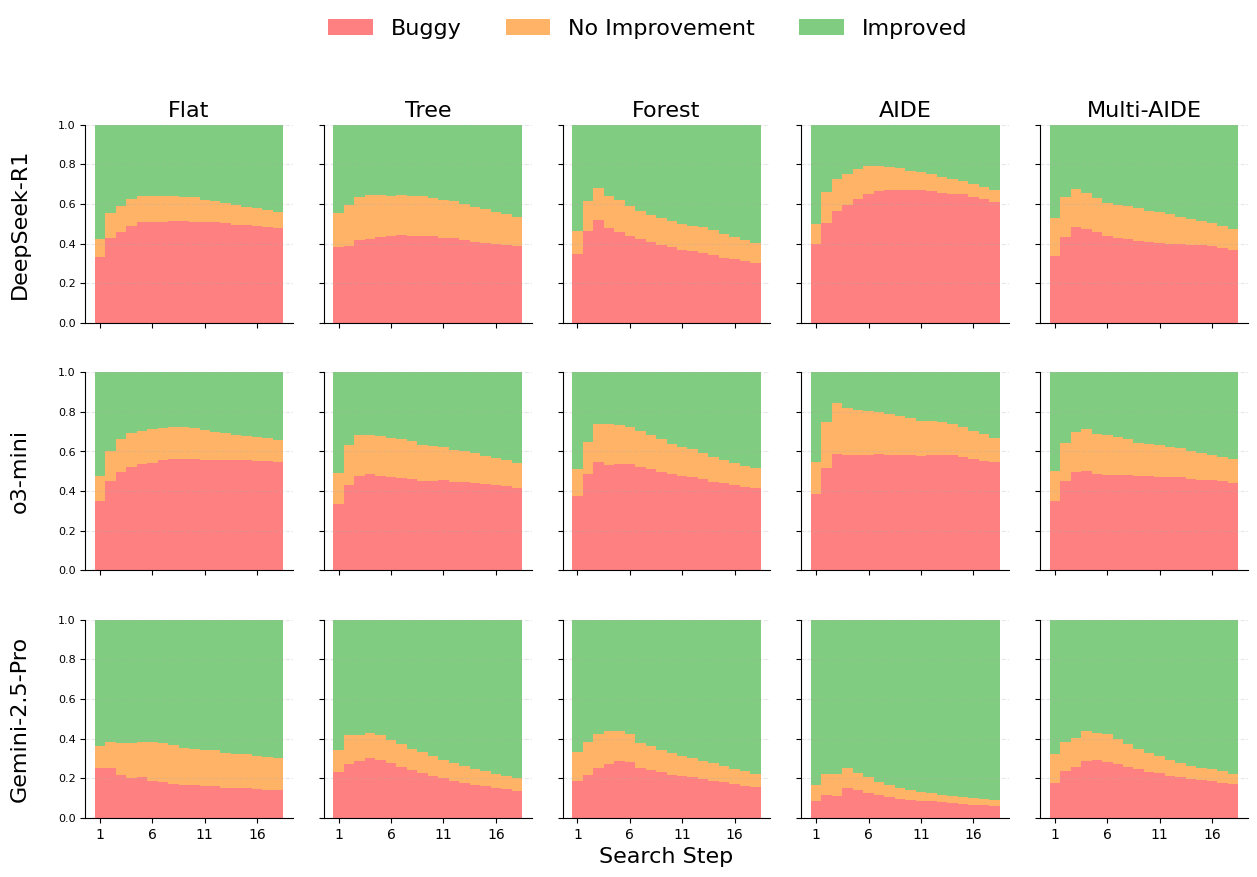

In [29]:
# buggy_percentage_first_k, no_improvement_first_k
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Changed to 3 rows for 3 models
# models = ['gemini-2.5-pro', 'o3-mini', 'deepseek-r1']  # Added third model
models = ['deepseek-r1', 'o3-mini', 'gemini-2.5-pro', ]  # Added third model
search_algos = ['flat', 'tree', 'forest', 'aide', 'multi_aide']
colors = ['#FF8080', '#FFB366', '#80CC80']  # Darker red, orange, green
labels = ['Buggy', 'No Improvement', 'Improved']
search_algos_map = {
    'flat': 'Flat',
    'tree': 'Tree',
    'forest': 'Forest',
    'aide': 'AIDE',
    'multi_aide': 'Multi-AIDE'
}

for row, model in enumerate(models):
    for col, search_algo in enumerate(search_algos):
        # First get all first_k values
        first_k_values = list(range(2, 20))

        # Initialize lists to store percentages for each first_k
        buggy_percentages = []
        no_improvement_percentages = []
        good_percentages = []

        for k in first_k_values:
            # For each k, average across all records and levels
            buggy_k_total = []
            no_improvement_k_total = []

            # Get all record indices
            # record_indices = sorted(list(buggy_percentage_first_k[search_algo][1][model].keys()))
            record_indices = list(range(1, 20))

            for record_idx in record_indices:
                for level in [1, 12, 125]:
                    # Get value for this specific k
                    try:
                        buggy_k_total.append(buggy_percentage_first_k[search_algo][level][model][record_idx][k])
                        no_improvement_k_total.append(no_improvement_first_k[search_algo][level][model][record_idx][k])
                    except KeyError:
                        continue

            # Average for this k value
            avg_buggy = np.mean(buggy_k_total)
            avg_no_improvement = np.mean(no_improvement_k_total)
            avg_good = 1 - avg_buggy - avg_no_improvement

            buggy_percentages.append(avg_buggy)
            no_improvement_percentages.append(avg_no_improvement)
            good_percentages.append(avg_good)

        x = range(len(first_k_values))  # k values on x-axis
        # Plot stacked bars for each record
        bottom = np.zeros(len(x))
        for data, color in zip([buggy_percentages, no_improvement_percentages, good_percentages], colors):
            axes[row, col].bar(x, data, bottom=bottom, color=color, edgecolor='none', width=1.0)
            bottom += np.array(data)

        # Set y-axis limits and format x-axis
        axes[row, col].set_ylim(0, 1)
        axes[row, col].set_xticks(x[::5])  # Show every 5th tick

        # Only show x labels for bottom row
        if row == 2:  # Changed from 1 to 2 for three models
            axes[row, col].set_xticklabels([x-1 for x in first_k_values[::5]], fontsize=10)
        else:
            axes[row, col].set_xticklabels([])

        # Only show y labels for first column
        if col == 0:
            axes[row, col].tick_params(axis='y', labelsize=8)
        else:
            axes[row, col].set_yticklabels([])

        axes[row, col].spines['top'].set_visible(False)
        axes[row, col].spines['right'].set_visible(False)

        if row == 0:
            axes[row, col].set_title(search_algos_map[search_algo], fontsize=16)
        if col == 0:
            # Format model names for y-axis labels
            model_label = {
                'gemini-2.5-pro': 'Gemini-2.5-Pro',
                'o3-mini': 'o3-mini',
                'deepseek-r1': 'DeepSeek-R1'
            }
            axes[row, 0].set_ylabel(model_label[model], rotation=90, labelpad=20, fontsize=16)

        # Add grid for better readability
        axes[row, col].grid(True, axis='y', linestyle='--', alpha=0.3)

# Create legend patches
label_patches = []
for i, lbl in enumerate(labels):
    label_patches.append(
        plt.Rectangle((0, 0), 1, 1, fc=colors[i], label=lbl, ec='none')
    )

fig.legend(label_patches, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02),
          ncol=3, frameon=False, fontsize=16)

plt.subplots_adjust(wspace=0.15, hspace=0.25)

# Add x-label to bottom row
axes[2, 2].set_xlabel('Search Step', fontsize=16)  # Changed from axes[1, 2] to axes[2, 2]

plt.savefig(f'figures/buggy_percentage_stackbar_progression_three_models.pdf', dpi=200, bbox_inches='tight')